# TM10007 Assignment template

In [184]:
# Run this to use from colab environment
!git clone https://github.com/Doesjka/TM10007_ML_g9.git

fatal: destination path 'TM10007_ML_g9' already exists and is not an empty directory.


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [185]:
import os
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn import model_selection
from sklearn import decomposition
import seaborn
import matplotlib.pyplot as plt

data = pd.read_csv('/content/TM10007_ML_g9/worclipo/Lipo_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 115
The number of columns: 494


## Splitting data in train and test set


In [186]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, data.index, test_size=0.25, random_state=42)
labels_train = X_train['label']
X_train = X_train.drop(columns='label')

## Handling missing data 
All features that exist of at least 50% zeros are deleted from the data. 
All remaining zeros are replaced by the mean of that feature. 

In [187]:
zeros = (X_train == 0).sum()
threshold = 0.5 * len(y_train)
feature_del = zeros[zeros > threshold]

X_train = X_train.drop(columns=feature_del.index)
print(f'{len(data.columns)-len(X_train.columns)} features were deleted')

24 features were deleted


In [188]:
more_zeros = (X_train == 0).sum()
columns_zeros = more_zeros[more_zeros > 0].index
print(f'Of the remaining features, {len(columns_zeros)} features have at least one zero')

for column in columns_zeros:
  X_train[column] = X_train[column].replace(0, X_train[column].mean())

X_train.head()

Of the remaining features, 13 features have at least one zero


,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,PREDICT_original_sf_cvar_std_2.5D,...,PREDICT_original_phasef_phasecong_entropy_WL3_N5,PREDICT_original_phasef_phasesym_max_WL3_N5,PREDICT_original_phasef_phasesym_mean_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
ID,,,,,,,,,,,,,,,,,,,,,
Lipo-109_0,0.583844,0.186896,34.451107,6.722055,10.180735,7.693644,0.835865,0.140146,0.042975,0.021382,...,13.499218,0.595900,0.150948,0.179697,1.000671,-0.006720,0.595900,5168.717384,0.282876,15.422384
Lipo-079_0,0.277017,0.208006,114.638641,48.569863,24.191826,21.735453,0.676173,0.202989,0.170108,0.051873,...,16.990462,0.584699,0.122545,0.172051,1.307963,0.748531,0.584699,33813.267247,0.235223,18.142855
Lipo-016_0,0.763359,0.149676,53.151475,5.660356,5.753999,3.586421,0.910377,0.092794,0.012439,0.005466,...,14.580329,0.511266,0.101406,0.149471,1.446552,1.283396,0.511266,10044.469584,0.191312,16.758114
Lipo-031_0,0.462099,0.202776,86.060279,29.701051,23.774149,16.589309,0.831939,0.184905,0.123727,0.045208,...,16.743750,0.550589,0.103938,0.157620,1.524738,1.533642,0.550589,20084.317295,0.191414,17.580300
Lipo-084_0,0.742849,0.122573,79.279980,13.321682,8.403819,5.551332,0.929835,0.069475,0.031738,0.015755,...,16.190209,0.403221,0.047259,0.104905,2.514477,6.180747,0.403221,6380.126314,0.011296,16.521040


## Scaling

In [189]:
scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.head()

,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,PREDICT_original_sf_cvar_std_2.5D,...,PREDICT_original_phasef_phasecong_entropy_WL3_N5,PREDICT_original_phasef_phasesym_max_WL3_N5,PREDICT_original_phasef_phasesym_mean_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,0.311125,-0.017272,-0.290374,-0.625588,-0.503757,-0.298036,0.043969,-0.168670,-0.497335,-0.461895,...,-0.122954,0.306292,0.558079,0.348609,-0.383366,-0.290081,0.306292,0.255447,0.585506,0.212310
1,-0.711701,0.162159,2.973356,4.607077,0.606347,0.782171,-0.636964,0.233081,1.266520,0.713537,...,1.447941,0.235205,0.199293,0.218387,-0.053610,-0.078527,0.235205,4.626823,0.237711,1.332169
2,0.909548,-0.333623,0.470754,-0.758343,-0.854490,-0.613996,0.361690,-0.471385,-0.920996,-1.075493,...,0.363495,-0.230848,-0.067723,-0.166153,0.095110,0.071294,-0.230848,0.999524,-0.082776,0.762152
3,-0.094719,0.117707,1.810182,2.247714,0.573255,0.386289,0.027230,0.117470,0.623021,0.456621,...,1.336933,0.018719,-0.035734,-0.027372,0.179010,0.141390,0.018719,2.531681,-0.082025,1.100598
4,0.841177,-0.563987,1.534216,0.199632,-0.644543,-0.462839,0.444658,-0.620463,-0.653242,-0.678835,...,1.087865,-0.916563,-0.751687,-0.925136,1.241099,1.443092,-0.916563,0.440317,-1.396613,0.664562


## PCA

[0.99622209 0.00377785]
[1.87150948e+08 1.15248769e+07]
0    -7.603568e-02
1     2.469519e+03
2     5.743447e-02
3     8.533135e-01
4     2.017002e-01
5    -1.002501e-01
6    -1.025994e-01
7    -1.025667e-01
8     2.649926e+07
9    -1.013003e-01
10    9.148979e-01
11   -1.162483e-01
12    1.963562e+02
13   -1.151459e-01
14   -6.557171e-02
15   -1.153272e-01
16   -9.963941e-02
17    5.195398e-02
18   -1.177688e-01
19   -1.050905e-01
20    3.380585e+06
21   -5.503025e-02
22    5.168334e-01
23   -1.098538e-01
24   -9.402796e-02
25    3.640110e+01
26   -9.363696e-02
27    4.131482e-02
28    6.614237e-01
29   -4.729039e-02
30    1.523895e+00
31   -1.112093e-01
32   -1.005809e-01
33    3.596387e-01
34   -3.332184e-02
35    2.198362e+02
36    5.949782e+06
37   -1.152507e-01
38    3.636812e-02
39    1.967287e+01
40    3.087306e+00
41   -8.131090e-02
42   -1.129364e-01
43    4.272272e+07
44    1.024446e+00
45   -3.247190e-02
46   -1.156341e-01
47    4.232677e-01
48    7.202777e-03
49   -6.61315

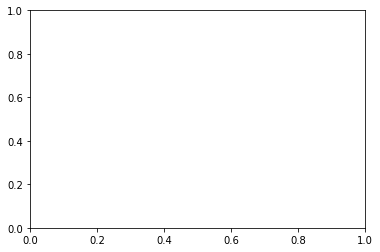

In [190]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled_df)
X_pca = pca.transform(X_train_scaled_df)
seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_train)
# plt.xscale('log')
# plt.yscale('log')
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# Nog een (tot nu toe mislukte) poging
pca_df = pd.DataFrame(pca.components_,columns=X_train_scaled_df.columns,index = ['PC-1','PC-2'])
max_feature = pca_df.idxmax(axis=1)
print(X_train_scaled_df[max_feature.iloc[1]])
seaborn.scatterplot(x=X_train_scaled_df[max_feature.iloc[0]], y=X_train_scaled_df[max_feature.iloc[1]], hue=labels_train)
print(max_feature)